## TOC:
* [Intro](#intro)
* [Operation](#operation)
* [Manual Observation](#manual)

<a id='intro'></a>
# Intro
This notebook is designed to serve as an example of how to manually control a PANOPTES unit using the high-level software interface. It also acts as a basic test of hardware functionality.

#### POCS

`POCS` is a high-level object that acts as the "brains" for the unit. We build an `Observatory` object that has knowledge of our hardware and then pass this object into the `POCS` object instance. While `POCS` is running it is responsible for moving the unit between the various _states_, doing safety checks (weather, darkness, hard drive space, etc.) as well as performing other tasks. So `POCS` decides which commands to send to the `Observatory` based on what _state_ it is in. The `Observatory` is then responsible for controlling individual hardware components.

Normal automated operation of a unit involves creating an `Observatory` and a `POCS` instance, which is then run in a non-interactive fashion, such as:

```python3
observatory = Observatory()
pocs = POCS(observatory)
pocs.initialize()
pocs.run()
```

The `pocs_shell` that is normally used wraps the statements above:

```
Welcome to POCS Shell! Type ? for help
POCS > setup_pocs
POCS > run_pocs
```

In this notebook we are goinng to create the `POCS` and `Observatory` instance but then interact with it manually rather than using the `pocs.run()` method. This notebook starts with some basic control and testing of the mount in the [Operation](#operation) section. The [Manual Observation](#manual) goes through a complete observation cycle similar to the POCS state machine.

---

### Setup

There are a few basic things that need to be set up before:

* Firmware updated for iOptron.
* Set Horizon limits and behaviour via handset (30° for limit and stop as behaviour).
* Define park position on via handset (operation steps below will test this).
* Make sure data has been downloaded  (see below).

##### Log files
You will also probably want to watch the log file. Assuming a standard POCS installation, the log files are in `/var/panoptes/logs/`. When running in a jupyter notebook (such as here), you can run the following in a separate terminal:

```
grc tail -F /var/panoptes/logs/ipykernel_launcher.py-all.log
```

The `grc` portion is optional and needs to be installed on Ubuntu (`sudo apt install grc`) but gives helpful color output to the log file. The `tail` command is standard on all linux systems. The `-F` option just means "follow".

##### Download data

If you need to download data files.  Note that the instructions should have had you set up a cron job which does this same thing every week, see [instructions here](https://github.com/panoptes/POCS/wiki/Cron-Jobs). There is no harm in re-running this but it does not need to be run every time. (~3MB - 50+MB depending on which files need to be downloaded)

In [ ]:
from pocs.utils.data import Downloader
Downloader().download_all_files()

<a id="operation"></a>

# Operation

### Initialization

In [1]:
# Load the required modules
from pocs.core import POCS
from pocs.observatory import Observatory
from pocs.utils import error

In [2]:
# Create the observatory object with simulators attached
# Could be any of: ['weather', 'night', 'camera', 'mount', 'all']
observatory = Observatory(simulator=['all']) 

In [3]:
# Create an instance of POCS and pass it the observatory instance
pocs = POCS(observatory) 

The `pocs` instance needs to be initialized, which will set up the cameras, mount, scheduler, etc.

In [4]:
pocs.initialize()

True

### Test home and park positions

By default the mount is parked when operations start. Here we want to simply unpark the mount, slew to the home position (with RA axis vertical and cameras pointing at Polaris), move around in a few directions, then park.

#### Home

In [5]:
# Easier to work with shorter name
mount = pocs.observatory.mount

# Unpark the mount
mount.unpark()

True

In [6]:
# Slew to home
mount.slew_to_home()

In [7]:
# We can check if at home
mount.is_home

True

In [8]:
# Or if parked
mount.is_parked

False

In [9]:
# Or slewing
mount.is_slewing

False

In [10]:
# Or tracking
mount.is_tracking

False

#### Move direction

We want to simply move the mount around a bit to test that directions work.

In [11]:
# Set mount to move at the fastest speed for manual movements
# Note: there is no high-level method for doing this so we use the underlying `query`
# command to send commands and values. This is not a common procedure as we normally
# leave it at the fastest speed.
mount.query('set_button_moving_rate', 9)

In [12]:
# Slew the Dec south
mount.move_direction(direction='south', seconds=3)

In [13]:
# Slew the RA to the west
mount.move_direction(direction='west', seconds=3)

In [14]:
# Set a slower speed just to test visible difference, then move again
# Note: it can be hard to tell the mount is even moving at slower speeds
mount.query('set_button_moving_rate', 7)
mount.move_direction(direction='north', seconds=3)
mount.move_direction(direction='east', seconds=3)

Since the above was at a slower movement rate this should not return to the exact home position. 

In [15]:
# Reset movement speed
mount.query('set_button_moving_rate', 9)

#### Park

When parking we usually want to first go home and then park:

In [16]:
mount.home_and_park()

In [17]:
mount.is_home

False

In [18]:
mount.is_parked

True

#### Status

We can check the status of the mount at any time. Right now this won't contain much information but once we have acquired a target you will see more information here:

In [19]:
mount.status()

{'tracking_rate': '1.0000',
 'ra_guide_rate': 0.5,
 'dec_guide_rate': 0.5,
 'movement_speed': '',
 'current_ra': <Longitude 84.65258608 deg>,
 'current_dec': <Latitude -10. deg>,
 'timestamp': <Time object: scale='utc' format='datetime' value=2018-08-09 11:02:54.924719>,
 'tracking_rate_ra': 1.0,
 'state': 'Parked'}

Note that we can also check the status on our `pocs` instance, which will recursively call `status` for all the objects in knows about. Again, this will also include target information as appropriate.

In [20]:
pocs.status()

{'state': 'sleeping',
 'system': {'free_space': 13.229215744000001},
 'observatory': {'mount': {'tracking_rate': '1.0000',
   'ra_guide_rate': 0.5,
   'dec_guide_rate': 0.5,
   'movement_speed': '',
   'current_ra': <Longitude 84.65258608 deg>,
   'current_dec': <Latitude -10. deg>,
   'timestamp': <Time object: scale='utc' format='datetime' value=2018-08-09 11:02:54.971165>,
   'tracking_rate_ra': 1.0,
   'state': 'Parked',
   'current_ha': <Longitude 12.67209515 hourangle>},
  'observer': {'siderealtime': '18h18m56.6533s',
   'utctime': <Time object: scale='utc' format='datetime' value=2018-08-09 11:02:54.965991>,
   'localtime': '2018-08-09 21:02:54',
   'local_evening_astro_time': <Time object: scale='utc' format='jd' value=2458340.8660200317>,
   'local_morning_astro_time': <Time object: scale='utc' format='jd' value=2458340.3022840945>,
   'local_sun_set_time': <Time object: scale='utc' format='jd' value=2458339.8036932736>,
   'local_sun_rise_time': <Time object: scale='utc' for

### Slew to position, take images

We want to give the mount a valid target, have it slew to and acquire target, then take an image with the cameras.

Here we create a target from a set of AltAz coordinates. Normally the targets are specifcied in an external targets file and the `pocs.observatory.get_observation` method is responsible for running the scheduler to detremine the most appropriate object.

In [21]:
from pocs.utils import altaz_to_radec
from pocs.utils import current_time

In [22]:
# Create a target for the given AltAz coordinates. To create AltAz we need to know where
# on earth we are and at what time we are looking.

alt = 70
az = 90

target = altaz_to_radec(
    alt=alt, 
    az=az, 
    location=pocs.observatory.earth_location, 
    obstime=current_time()
)

target

<SkyCoord (ICRS): (ra, dec) in deg
    (298.09280778, -31.54299888)>

In [23]:
# Make sure our mount is unparked
mount.unpark()

True

In [24]:
mount.set_target_coordinates(target)

True

In [25]:
mount.slew_to_target()

True

In [26]:
mount.is_tracking

True

In [27]:
# Track when camera is done exposing
camera_events = dict()

# Take exposure with each camera
for cam_name, camera in pocs.observatory.cameras.items():

    try:
        # Start the exposures
        cam_event = camera.take_exposure(
            seconds=2,
            filename='/var/panoptes/images/temp/test_pic_{}.cr2'.format(cam_name)
        )

        # Store the camera event
        camera_events[cam_name] = cam_event
    except Exception as e:
        print("Problem waiting for images: {}".format(e))        

In [28]:
# See our stored events
camera_events

{'Cam00': <threading.Event at 0x7f2b28892b38>,
 'Cam01': <threading.Event at 0x7f2b288a4d68>}

In [29]:
# We can check if the event is complete
camera_events['Cam00'].is_set()

False

Now let's very we got a picture by making a jpg. _(Note: the camera simulator won't actually take picture so you will just get an image of a timestamp)._

In [30]:
# Show images in the notebook
from IPython.display import Image as ShowImage
from IPython.display import display

from pocs.utils.images import make_pretty_image

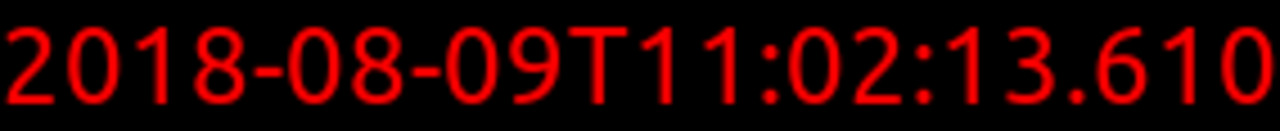

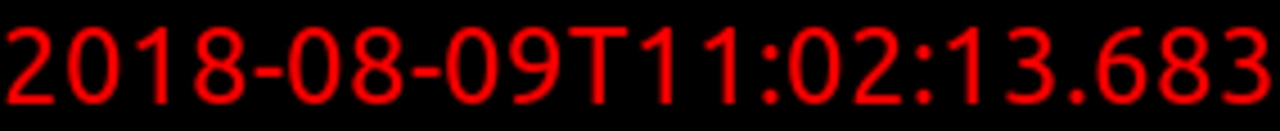

In [31]:
# Turn it into a pretty image
for cam_name in pocs.observatory.cameras.keys():
    jpg_fn = make_pretty_image('/var/panoptes/images/temp/test_pic_{}.cr2'.format(cam_name))
    display(ShowImage(jpg_fn, width=500))

<a id="manual"></a>
## Manual `Observation`

POCS doesn't usually work directly with targets but instead creates an `Observation`. This object has coordinates (the `target` above is just a set of coordinates) as well as information about the exposures, including the exposure time, the minimum number of exposures needed, the observation's priority, etc.

In [32]:
# Show the observations
for name, obs in pocs.observatory.scheduler.observations.items():
    print(obs)

Kepler 1100: 120.0 s exposures in blocks of 10, minimum 60, priority 125
KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 200
HD 23630: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 189733: 100.0 s exposures in blocks of 10, minimum 60, priority 105
HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 140: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 104: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 44: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 2: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 24: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 77: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 43: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 36: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 11: 120.0 s exp

### Schedule

We can set the current exposure. Normally this would be done by the scheduler, which would take into account the `priority`, the sky location, proximity to moon, etc. The `Observatory` itself does not restrict what `Observation` can be set and it is the job of the scheduler to check for ideal conditions. However, the mount will refuse to move to coordinates below the horizon.

> If you are running this notebook in the daytime and want to actually go to a target, change the below to a target that is up (at least 30° above horizon) and make sure to include the `night` simulator when constructing the `Observatory` object, i.e.: `Observatory(simulator=['night', 'weather'])`.

> It is your job to make sure it is not pointing at the Sun or raining or something else harmful. Remember, you are the "brains" while running this notebook.

In [33]:
# Get one observation
observation = pocs.observatory.scheduler.observations['HD 189733']

In [34]:
# Show observation status - some of these values change with time, some don't
observation.status()

{'current_exp': 0,
 'dec_mnt': 22.710852777777777,
 'equinox': 'J2000.000',
 'exp_set_size': 10,
 'exp_time': 100.0,
 'field_dec': 22.710852777777777,
 'field_name': 'HD 189733',
 'field_ra': 300.18213749999995,
 'merit': 0.0,
 'min_nexp': 60,
 'minimum_duration': 6000.0,
 'priority': 105.0,
 'ra_mnt': 300.18213749999995,
 'seq_time': None,
 'set_duration': 1000.0}

In [35]:
# Set the current observation - also sets the mount
pocs.observatory.current_observation = observation

In [36]:
# Check we have target set
mount.has_target

True

### Slew

In [37]:
# Make sure we are unparked
mount.unpark()

True

In [38]:
# Slew to our target
mount.slew_to_target()

True

### Check pointing

Before we start normal observations, we take a 30 second image in order to check if the mount is pointed at the coordinates we expect.

> Note: Currently all of the logic to do a pointing image is in the `pointing` state. Ideally this will be moved into the `Observatory` object so we have a high-level method, i.e. `pocs.observatory.take_pointing_image()`, that would take care of all of this for us. See the `observe()` and `analyze_recent()` examples below. In the future this may change. However here it is still a good example of how to use some of the code:

#### Setup pointing image

In [39]:
observation = pocs.observatory.current_observation

# Same FITS headers as current observation
fits_headers = pocs.observatory.get_standard_headers(
    observation=observation
)
fits_headers['POINTING'] = 'True'
fits_headers

{'airmass': 2.101390579354788,
 'creator': 'POCSv0.6.0',
 'elevation': 100.0,
 'ha_mnt': 22.304145565902168,
 'latitude': -33.7738,
 'longitude': 151.1126,
 'moon_fraction': 0.05747058287772033,
 'moon_separation': 42.82503471342596,
 'observer': 'BigMac',
 'origin': 'Project PANOPTES',
 'tracking_rate_ra': 1.0,
 'current_exp': 0,
 'dec_mnt': 22.710852777777777,
 'equinox': 2000.0,
 'exp_set_size': 10,
 'exp_time': 100.0,
 'field_dec': 22.710852777777777,
 'field_name': 'HD 189733',
 'field_ra': 300.18213749999995,
 'merit': 0.0,
 'min_nexp': 60,
 'minimum_duration': 6000.0,
 'priority': 105.0,
 'ra_mnt': 300.18213749999995,
 'seq_time': '20180809T110257',
 'set_duration': 1000.0,
 'POINTING': 'True'}

#### Take picture

In [40]:
import time

# Take an image with the primary camera
try:
    # Start the exposures
    camera_event = pocs.observatory.primary_camera.take_observation(
        observation,
        fits_headers,
        exp_time=30.,
        filename='pointing00'
    )
except Exception as e:
    print("Problem: ", e)
    
# Wait for the image
wait_time_elapsed = 0.
timeout = 35.
wait_interval = 3.
while camera_event.is_set() is False:
    
    print('Waiting for images: {} seconds'.format(wait_time_elapsed))

    if wait_time_elapsed > timeout:
        raise error.Timeout("Timeout waiting for pointing image")

    time.sleep(wait_interval)
    wait_time_elapsed += wait_interval

Waiting for images: 0.0 seconds


#### Plate-solve

In [41]:
from pocs.images import Image as PocsImage

# Get information about the last exposure, which was the pointing image we just took
pointing_id, pointing_path = pocs.observatory.current_observation.last_exposure

# Create an Image object
pointing_image = PocsImage(
    pointing_path,
    location=pocs.observatory.earth_location
)

# Do the plate-solving
pointing_image.solve_field()

# Set this as our pointing image. This is used as a reference for tracking
observation.pointing_image = pointing_image

print("Pointing Coords: ", pointing_image.pointing)
print("Pointing Error: ", pointing_image.pointing_error)

Pointing Coords:  <SkyCoord (ICRS): (ra, dec) in deg
    (303.20188114, 46.0172759)>
Pointing Error:  OffsetError(delta_ra=<Angle 5894.968104 arcsec>, delta_dec=<Angle 5617.44322776 arcsec>, magnitude=<Angle 6984.43269828 arcsec>)


#### Take observation images 
Since we set `pocs.observatory.current_observation`, that means we are ready to simply `observe`. 

If you want to change the exposure time you can uncomment the next lines.

In [42]:
# from astropy import units as u
# pocs.observatory.current_observation.exp_time = 10 * u.second

In [43]:
import time

# Observe - capture the camera events
camera_events = pocs.observatory.observe()

wait_time_elapsed = 0.
wait_interval = 5.
timeout = pocs.observatory.current_observation.exp_time.value + 10

# Wait for cameras to finish exposing
while not all([event.is_set() for event in camera_events.values()]):

    print('Waiting for images: {} seconds'.format(wait_time_elapsed))

    # Don't wait forever if something is going wrong
    if wait_time_elapsed > timeout:
        raise error.Timeout

    time.sleep(wait_interval)
    wait_time_elapsed += wait_interval

Waiting for images: 0.0 seconds


#### Analyze images

We can also simply instruct the `Observatory` to `analyze_recent()`. This will take care of making the pretty image, converting the raw image to FITS, and plate-solving the FITS file for the primary camera (usually just the first camera but can be set in the config).

In [44]:
offset_info = pocs.observatory.analyze_recent()
offset_info

OffsetError(delta_ra=<Angle 0. arcsec>, delta_dec=<Angle 0. arcsec>, magnitude=<Angle 0. arcsec>)

In [45]:
# Check the exposure list
for img_id, img_path in pocs.observatory.current_observation.exposure_list.items():
    print(img_id, img_path)

BigMac_SC8254_20180809T110258 /var/panoptes//images/fields/Hd189733/SC8254/20180809T110257//pointing00.fits
BigMac_SC8254_20180809T110304 /var/panoptes//images/fields/Hd189733/SC8254/20180809T110257//20180809T110304.fits


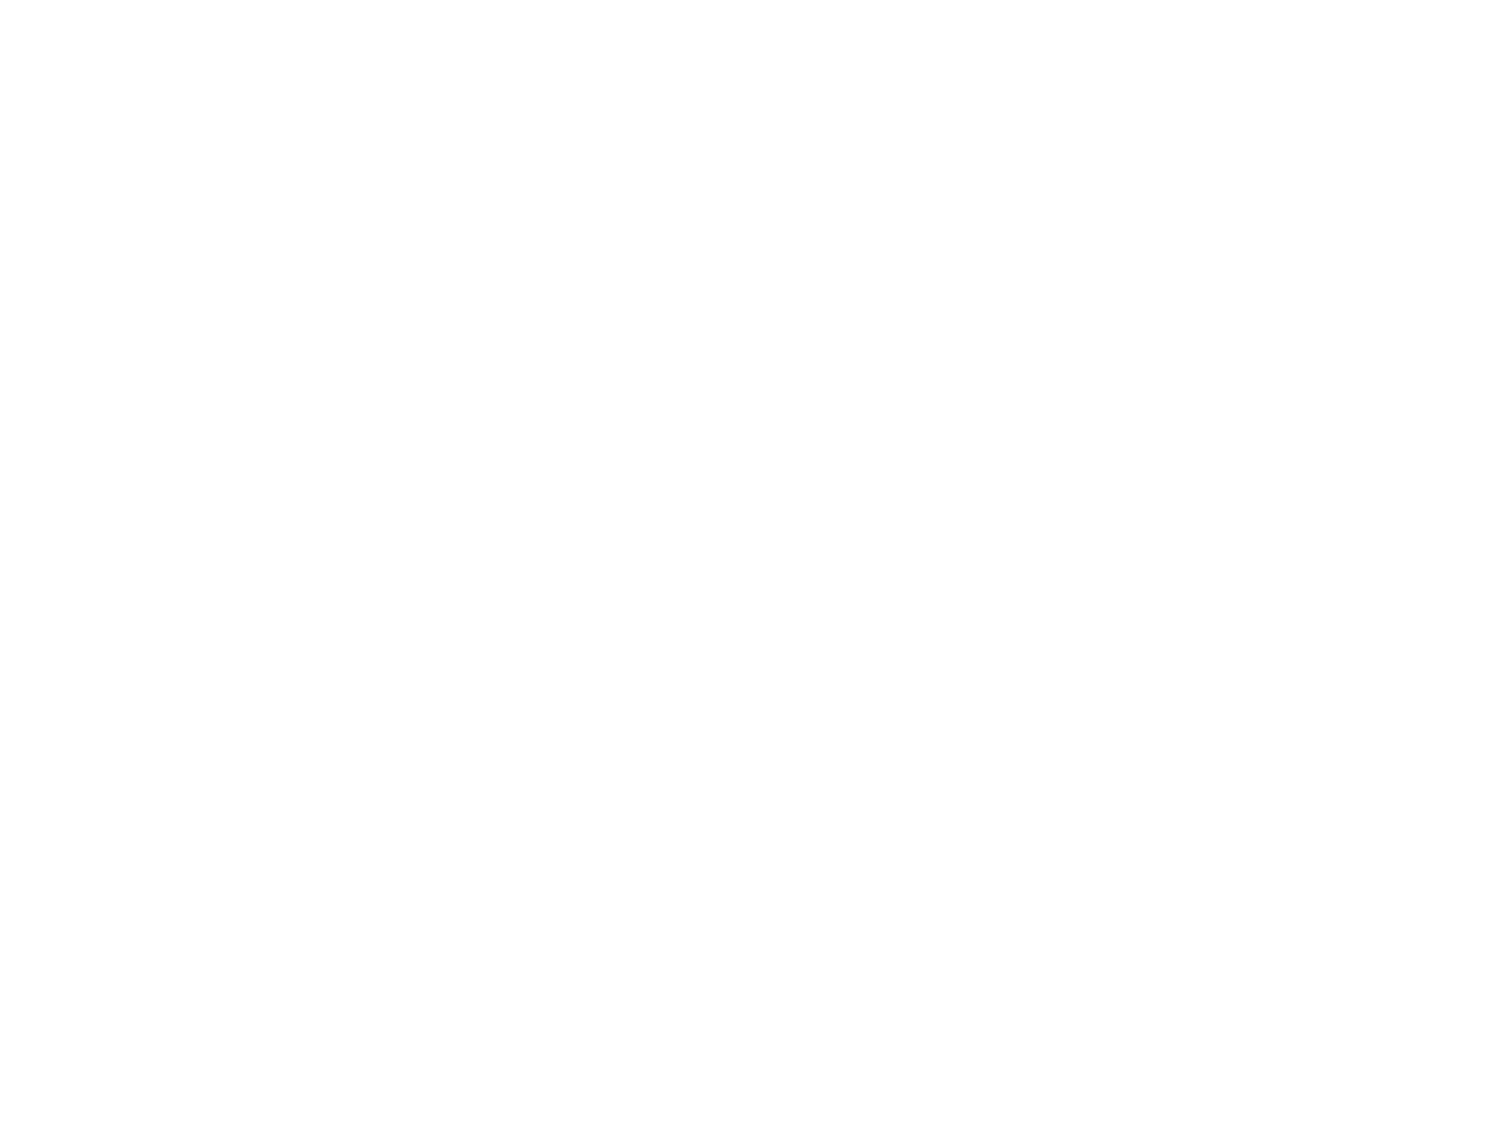

In [46]:
recent_image_path = list(pocs.observatory.current_observation.exposure_list.values())[-1]
display(ShowImage(recent_image_path.replace('.fits', '.jpg'), width=500))

#### Tracking adjustment

With the offset info above we can instruct the mount to do a tracking correction.

> Note: Unfortunately this doesn't return a success variable currently. Keep checking the logs for output during long running operations.

In [47]:
# Perform tracking update
pocs.observatory.update_tracking()

#### Wash, rinse, repeat

The POCS state machine would continue to go through a `observe`->`analyze_recent`->`update-tracking` loop for `pocs.observatory.current_observation.min_nexp` times. At that point it would call the scheduler again. The scheduler will optimally choose to stay on this save field, taking `pocs.observatory.current_observation.exp_set_size` images each time before calling the scheduler again.

In [48]:
# Show our status
pocs.status()

{'state': 'sleeping',
 'system': {'free_space': 13.226127360000001},
 'observatory': {'mount': {'tracking_rate': '1.0000',
   'ra_guide_rate': 0.5,
   'dec_guide_rate': 0.5,
   'movement_speed': '',
   'current_ra': <Longitude 298.09280778 deg>,
   'current_dec': <Latitude -31.54299888 deg>,
   'mount_target_ra': <Longitude 298.09280778 deg>,
   'mount_target_dec': <Latitude -31.54299888 deg>,
   'timestamp': <Time object: scale='utc' format='datetime' value=2018-08-09 11:03:12.632679>,
   'tracking_rate_ra': 1.0,
   'state': 'Tracking',
   'current_ha': <Longitude 22.4476662 hourangle>,
   'mount_target_ha': <Longitude 22.4476662 hourangle>},
  'observation': {'current_exp': 0,
   'dec_mnt': 22.710852777777777,
   'equinox': 'J2000.000',
   'exp_set_size': 10,
   'exp_time': 100.0,
   'field_dec': 22.710852777777777,
   'field_name': 'HD 189733',
   'field_ra': 300.18213749999995,
   'merit': 0.0,
   'min_nexp': 60,
   'minimum_duration': 6000.0,
   'priority': 105.0,
   'ra_mnt': 300

#### Home and park

In [49]:
# Now go back home
pocs.observatory.mount.home_and_park()

#### Cleanup


The POCS state machine would also do some `housekeeping` after successfully parking. This involves compressing the FITS files, making a timelapse movie of the observations, and uploading the files to our google storage buckets. Finally, POCS would put itself to sleep during the day, checking safety conditions (day, weather) until it was safe again.